In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv3D, Flatten, LSTM, concatenate, MaxPooling3D, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

2024-03-13 09:43:53.066367: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 09:43:53.082735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 09:43:53.082755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 09:43:53.083323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 09:43:53.086830: I tensorflow/core/platform/cpu_feature_guar

LOADING THE DATA

In [2]:
num_realizations = 500  
data_dir = '/mnt/c/Users/mriga/OneDrive/Documents/research_test/origen_interview_data'  # Data directory

In [15]:
poros, perms_x, perms_y, perms_z = [], [], [], []
trans_x, trans_y, trans_z = [], [], []
satnums, depths, porvs = [], [], []
woprs, bhps = [], []

In [16]:
def load_realization_data(realization_num):

    # Load porosity
    poro_file = os.path.join(data_dir, f'PORO/sim{realization_num}_poro.npy')
    poro = np.load(poro_file).reshape(15, 25, 24)

    # Load PermX
    permx_file = os.path.join(data_dir, f'PERMX/sim{realization_num}_permx.npy')
    permx = np.load(permx_file).reshape(15, 25, 24)

    # Load PermY
    permy_file = os.path.join(data_dir, f'PERMY/sim{realization_num}_permy.npy')
    permy = np.load(permy_file).reshape(15, 25, 24)

    # Load PermZ
    permy_file = os.path.join(data_dir, f'PERMZ/sim{realization_num}_permz.npy')
    permz = np.load(permy_file).reshape(15, 25, 24)

    # Load Depth
    depth_file = os.path.join(data_dir, f'DEPTH/sim{realization_num}_depth.npy')
    depth = np.load(permy_file).reshape(15, 25, 24)

    # Load BHP
    bhp_file = os.path.join(data_dir, f'BHP/sim{realization_num}_bhps.npy')
    bhp = np.load(bhp_file)

    # Load WOPR
    wopr_file = os.path.join(data_dir, f'WOPR/sim{realization_num}_WOPR.npy')
    wopr = np.load(wopr_file)

    
    return poro, permx, permy, permz, depth, wopr, bhp


for i in range(1, num_realizations + 1):
    poro, permx, permy, permz, depth, wopr, bhp = load_realization_data(i)
    
    poros.append(poro)
    woprs.append(wopr)
    bhps.append(bhp)
    perms_x.append(permx)
    perms_y.append(permy)
    perms_z.append(permz)
    depths.append(depth)

In [5]:
print("poros shape:", len(poros), "*", poros[0].shape)
print("woprs shape:", len(woprs), "*", woprs[0].shape)
print("bhps shape:", len(bhps), "*", bhps[0].shape)

poros shape: 500 * (15, 25, 24)
woprs shape: 500 * (300, 7)
bhps shape: 500 * (300, 7)


In [17]:
## Normalize 3D data (poros)
poros_flat = np.concatenate([p.reshape(-1, 1) for p in poros], axis=0)  
scaler_poro = MinMaxScaler().fit(poros_flat)
normalized_poros = [scaler_poro.transform(p.reshape(-1, 1)).reshape(15, 25, 24) for p in poros]

## Normalize 3D data (DEPTH)
depth_flat = np.concatenate([p.reshape(-1, 1) for p in depths], axis=0)  
scaler_depth = MinMaxScaler().fit(depth_flat)
normalized_depth = [scaler_depth.transform(p.reshape(-1, 1)).reshape(15, 25, 24) for p in depths]

## Normalize time-series data (woprs and bhps)
bhps_flat = np.concatenate(bhps, axis=0) 
woprs_flat = np.concatenate(woprs, axis=0) 

scaler_bhps = MinMaxScaler().fit(bhps_flat)
scaler_woprs = MinMaxScaler().fit(woprs_flat)

normalized_bhps = [scaler_bhps.transform(b) for b in bhps]
normalized_woprs = [scaler_woprs.transform(w) for w in woprs]

In [21]:
train_split = 450  # First 450 realizations for training
test_split = 475  # Next 25 realizations for testing

## Training data
X_train_poros = np.array(normalized_poros[:train_split])
X_train_depth = np.array(normalized_depth[:train_split])
X_train_bhps = np.array(normalized_bhps[:train_split])
Y_train_woprs = np.array(normalized_woprs[:train_split])

## Testing data
X_test_poros = np.array(normalized_poros[train_split:test_split])
X_test_depth = np.array(normalized_depth[train_split:test_split])
X_test_bhps = np.array(normalized_bhps[train_split:test_split])
Y_test_woprs = np.array(normalized_woprs[train_split:test_split])

## Validation data (Final 25 realizations for validation)
X_val_poros = np.array(normalized_poros[test_split:])
X_val_depth = np.array(normalized_depth[test_split:])
X_val_bhps = np.array(normalized_bhps[test_split:])
Y_val_woprs = np.array(normalized_woprs[test_split:])

## Add a channel dimension to poros data for CNN
X_train_poros = np.expand_dims(X_train_poros, axis=-1)
X_test_poros = np.expand_dims(X_test_poros, axis=-1)
X_val_poros = np.expand_dims(X_val_poros, axis=-1)

## Add a channel dimension to depth data for CNN
X_train_depth = np.expand_dims(X_train_depth, axis=-1)
X_test_depth = np.expand_dims(X_test_depth, axis=-1)
X_val_depth = np.expand_dims(X_val_depth, axis=-1)

TRAINING/MODEL IMPLEMENTATION

In [22]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [23]:
l2_reg = 0.00001
dropout_rate = 0.25

In [30]:
## Inputs

## 3D data input (porosity)
poro_input = Input(shape=(15, 25, 24, 1)) 

## 3D data input (depth)
depth_input = Input(shape=(15, 25, 24, 1))

## Time-series data input (BHPs)
bhps_input = Input(shape=(300, 7))  # 300 time steps, 7 wells

# bhps_input = Input(shape=(300, 1))  # 300 time steps, 1 well

## 3D CNN branch for porosity data
cnn_branch_poro = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same',
                    kernel_regularizer=l2(l2_reg))(poro_input)
cnn_branch_poro = Dropout(dropout_rate)(cnn_branch_poro)
cnn_branch_poro = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_poro)
cnn_branch_poro = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same',
                    kernel_regularizer=l2(l2_reg))(cnn_branch_poro)
cnn_branch_poro = Dropout(dropout_rate)(cnn_branch_poro)
cnn_branch_poro = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_poro)
cnn_branch_poro = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same',
                    kernel_regularizer=l2(l2_reg))(cnn_branch_poro)
cnn_branch_poro = Dropout(dropout_rate)(cnn_branch_poro)
cnn_branch_poro = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_poro)
cnn_branch_poro = Flatten()(cnn_branch_poro)

## 3D CNN branch for depth data
# cnn_branch_depth = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same',
#                     kernel_regularizer=l2(l2_reg))(depth_input)
# cnn_branch_depth = Dropout(dropout_rate)(cnn_branch_depth)
# cnn_branch_depth = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_depth)
# cnn_branch_depth = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same',
#                     kernel_regularizer=l2(l2_reg))(cnn_branch_depth)
# cnn_branch_depth = Dropout(dropout_rate)(cnn_branch_depth)
# cnn_branch_depth = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_depth)
# cnn_branch_depth = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same',
#                     kernel_regularizer=l2(l2_reg))(cnn_branch_depth)
# cnn_branch_depth = Dropout(dropout_rate)(cnn_branch_depth)
# cnn_branch_depth = MaxPooling3D(pool_size=(2, 2, 2))(cnn_branch_depth)
# cnn_branch_depth = Flatten()(cnn_branch_depth)

# LSTM branch for BHPs time-series data
lstm_branch = LSTM(64, return_sequences=True, kernel_regularizer=l2(l2_reg))(bhps_input)
lstm_branch = LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg))(lstm_branch)
lstm_branch = LSTM(256, return_sequences=False, kernel_regularizer=l2(l2_reg))(lstm_branch)

# Concatenate the outputs from both branches
concatenated = concatenate([cnn_branch_poro, lstm_branch])

# concatenated = concatenate([cnn_branch_poro, cnn_branch_depth, lstm_branch])

# Final dense layers
dense_layer = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
dense_layer = Dropout(0.5)(dense_layer)  
dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)
dense_layer = Dropout(0.5)(dense_layer)  
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)

output = Dense(300 * 7, activation='linear', kernel_regularizer=l2(l2_reg))(dense_layer)  # Predicting 300 time steps for 7 wells
output = tf.reshape(output, (-1, 300, 7))  

# output = Dense(300, activation='linear', kernel_regularizer=l2(l2_reg))(dense_layer)  # Predicting 300 time steps for 1 well

# model = Model(inputs=[poro_input, bhps_input], outputs=output)
model = Model(inputs=[poro_input, depth_input, bhps_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 15, 25, 24, 1)]      0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 15, 25, 24, 1)]      0         []                            
                                                                                                  
 conv3d_3 (Conv3D)           (None, 15, 25, 24, 64)       1792      ['input_3[0][0]']             
                                                                                                  
 conv3d_6 (Conv3D)           (None, 15, 25, 24, 64)       1792      ['input_4[0][0]']             
                                                                                            

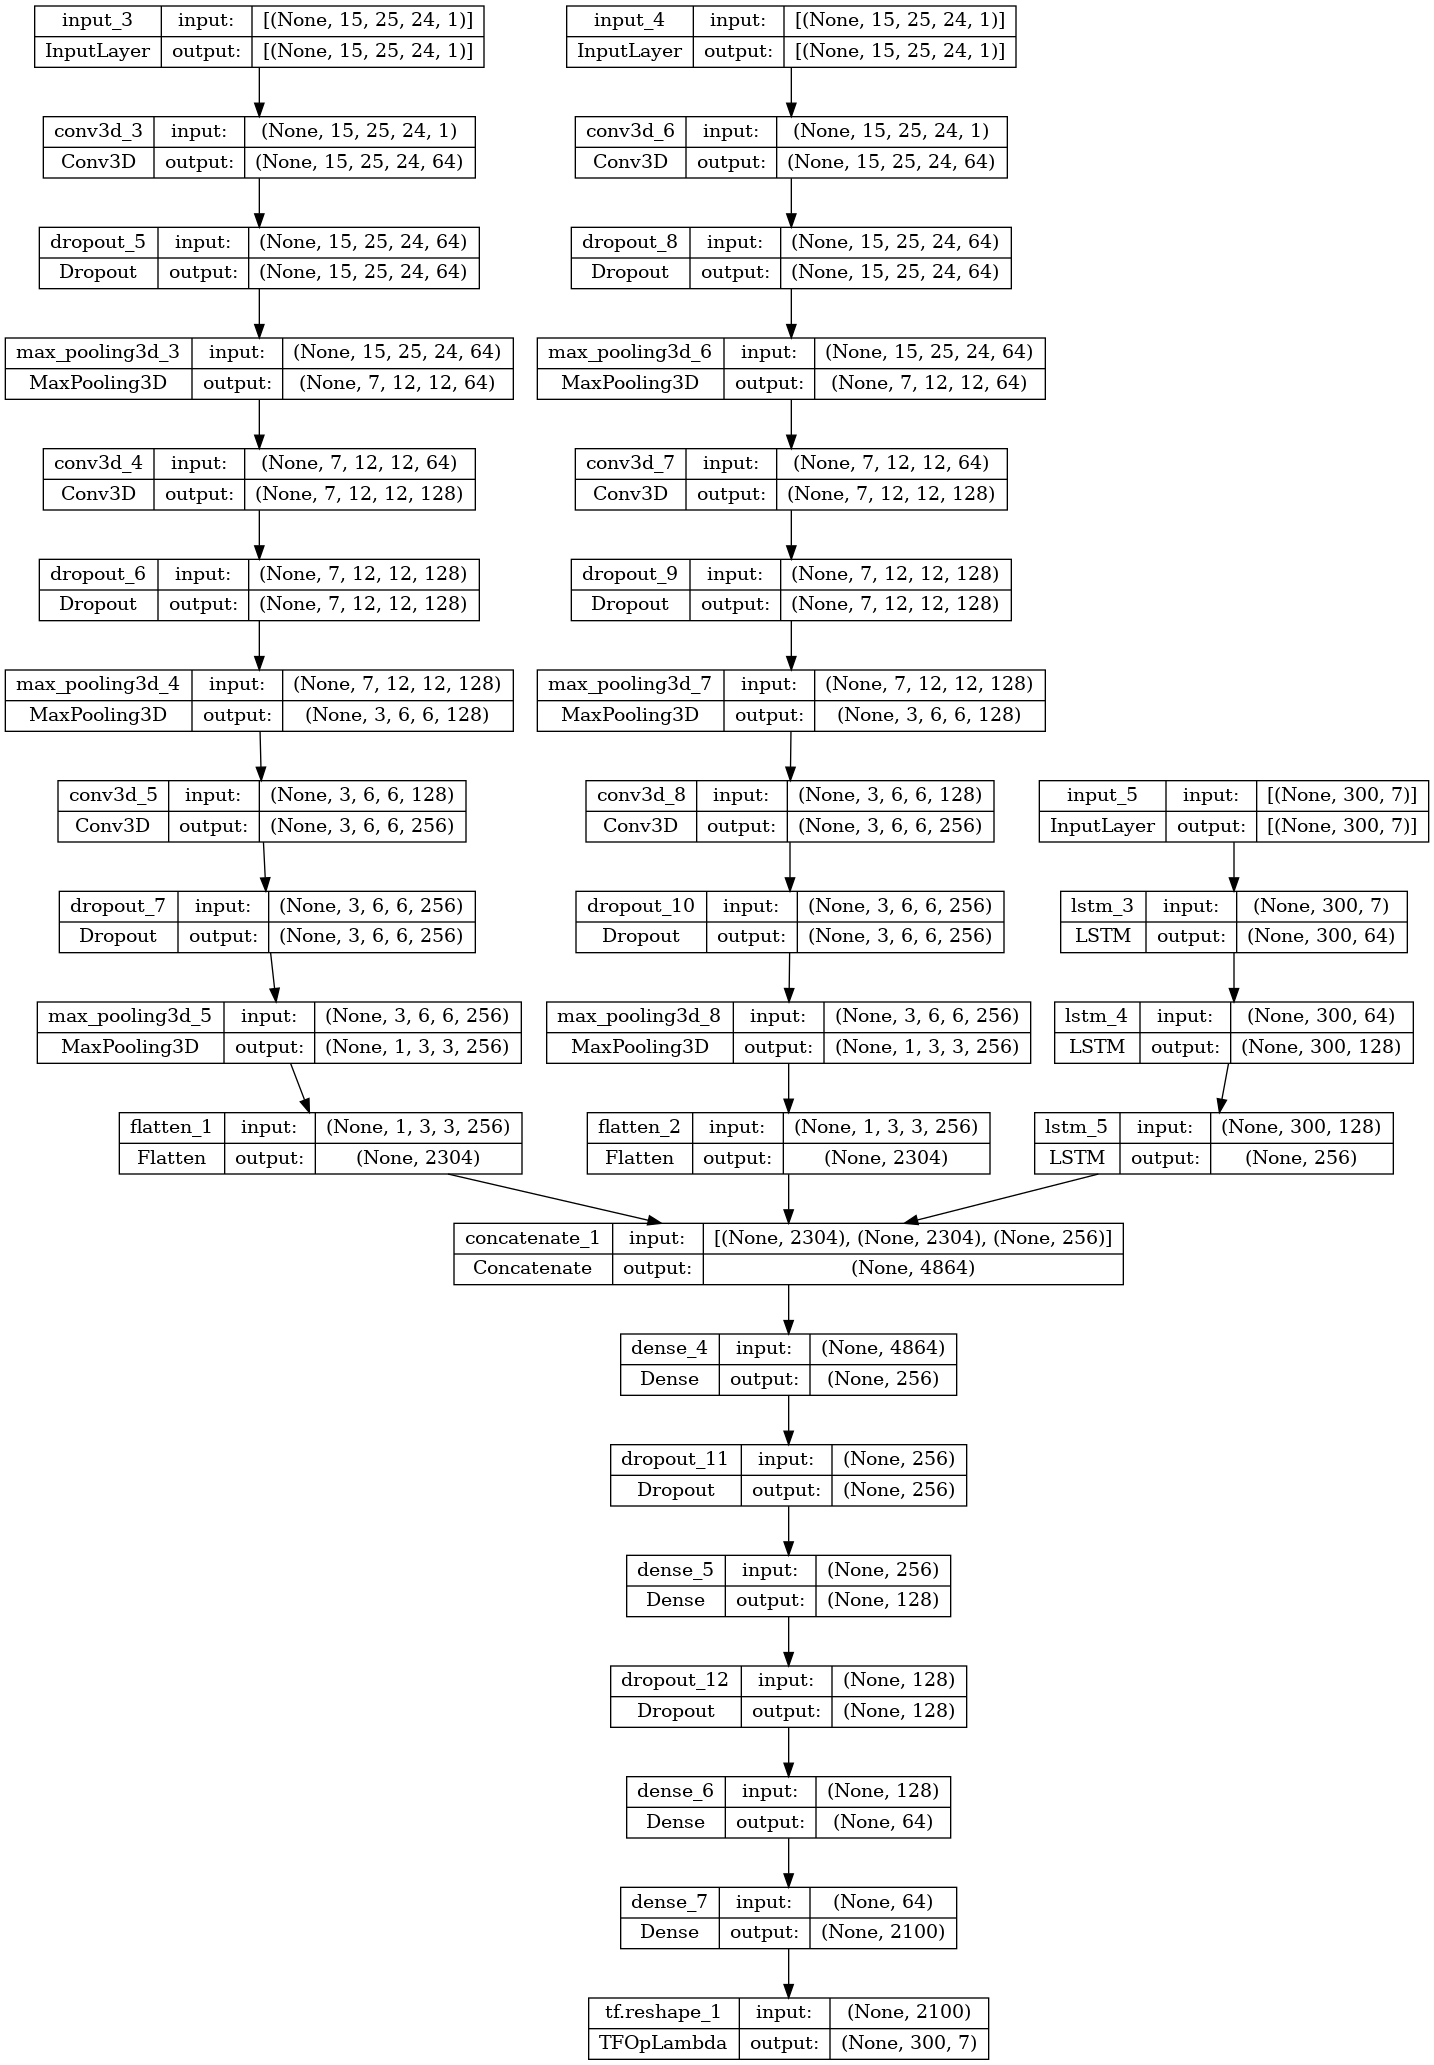

In [31]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history = model.fit([X_train_poros, X_train_bhps], Y_train_woprs, validation_data= ([X_val_poros, X_val_bhps], Y_val_woprs), epochs=150, batch_size=4,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/150


2024-03-13 09:45:48.060107: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-13 09:45:48.249870: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 09:45:49.108010: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f57bcef80b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 09:45:49.108043: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-03-13 09:45:49.111106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710337549.162751   71384 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 [==============================] - 10s 58ms/step - loss: 0.0189 - val_loss: 0.0118 - lr: 0.0010
Epoch 2/150
113/113 [==============================] - 6s 49ms/step - loss: 0.0123 - val_loss: 0.0103 - lr: 0.0010
Epoch 3/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0112 - val_loss: 0.0096 - lr: 0.0010
Epoch 4/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0110 - val_loss: 0.0095 - lr: 0.0010
Epoch 5/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0104 - val_loss: 0.0089 - lr: 0.0010
Epoch 6/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0100 - val_loss: 0.0090 - lr: 0.0010
Epoch 7/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0095 - val_loss: 0.0087 - lr: 0.0010
Epoch 8/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0089 - val_loss: 0.0077 - lr: 0.0010
Epoch 9/150
113/113 [==============================] - 5s 48ms/step - loss: 0.0083 - val_lo

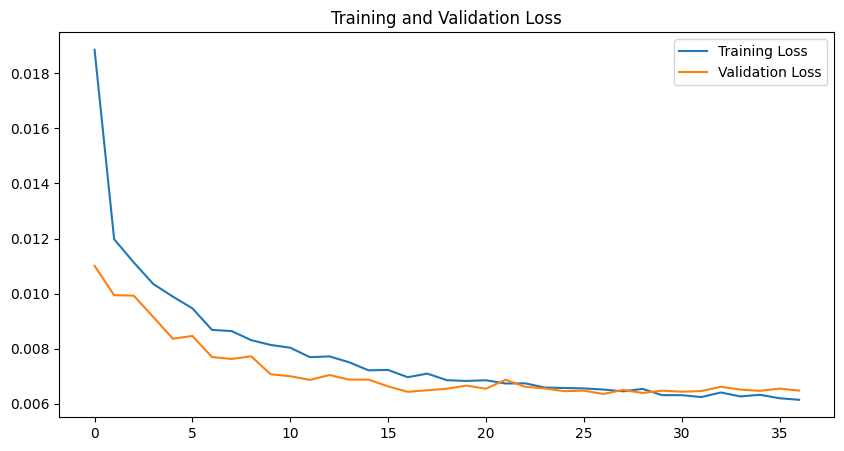

In [33]:
training_loss = np.array(history.history['loss'])
validation_loss = np.array(history.history['val_loss'])

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
test_loss = model.evaluate([X_test_poros, X_test_bhps], Y_test_woprs)
print('Test loss:', test_loss)

1/1 [==============================] - 0s 321ms/step - loss: 0.0076
Test loss: 0.00759940966963768


OUTPUT RESULTS

In [25]:
test_predictions = model.predict([X_test_poros, X_test_bhps])

test_predictions_flat = test_predictions.reshape(-1, 7)
test_predictions_unnorm = scaler_woprs.inverse_transform(test_predictions_flat)
test_predictions_unnorm = test_predictions_unnorm.reshape(-1, 7, 300)  # Reshape back to [25 x 7 x 300]

np.save('results_test.npy', test_predictions_unnorm)

1/1 [==============================] - 0s 97ms/step


In [ ]:
np.save('loss_training.npy', training_loss)
np.save('loss_testing.npy', validation_loss)

PLOTTING

In [26]:
test_predictions = model.predict([X_test_poros, X_test_bhps])

test_predictions_flat = test_predictions.reshape(-1, 7)
test_predictions_unnorm = scaler_woprs.inverse_transform(test_predictions_flat)
test_predictions_unnorm = test_predictions_unnorm.reshape(-1, 300, 7)

1/1 [==============================] - 0s 77ms/step


In [27]:
Y_test_woprs_flat = Y_test_woprs.reshape(-1, 7) 
Y_test_woprs_unnorm = scaler_woprs.inverse_transform(Y_test_woprs_flat)
Y_test_woprs_unnorm = Y_test_woprs_unnorm.reshape(-1, 300, 7) 

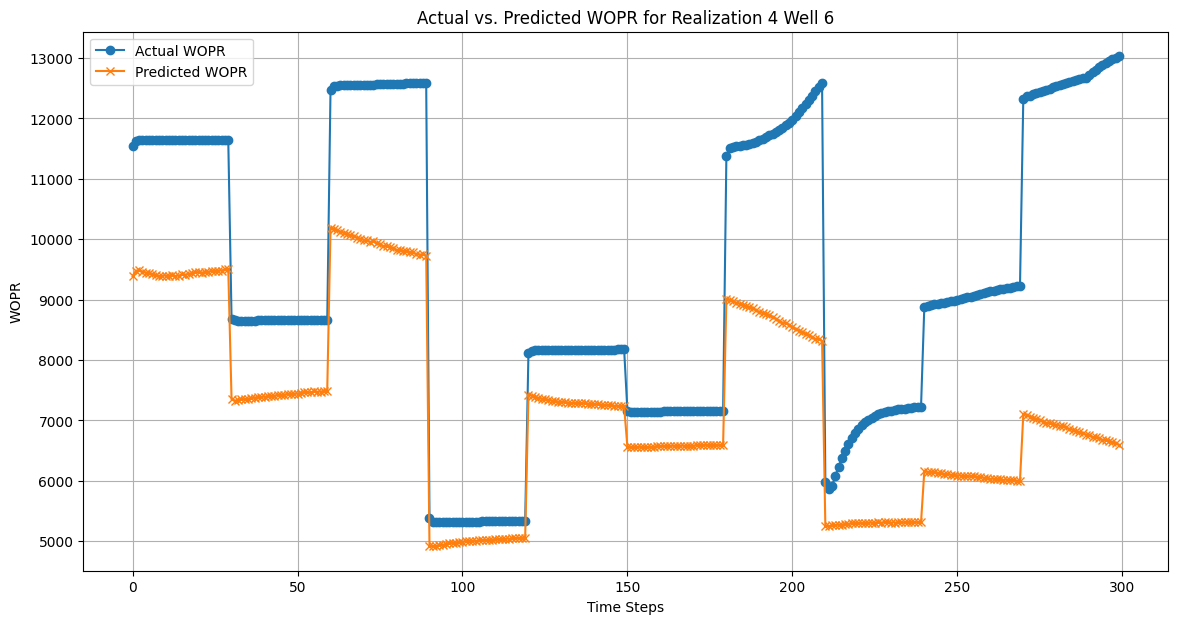

In [28]:
num_realizations = 25  
num_wells = 7
random_realization = random.randint(0, num_realizations - 1)
random_well = random.randint(0, num_wells - 1)


actual_wopr = Y_test_woprs_unnorm[random_realization, :, random_well]
predicted_wopr = test_predictions_unnorm[random_realization, :, random_well]


plt.figure(figsize=(14, 7))
plt.plot(actual_wopr, label='Actual WOPR', marker='o')
plt.plot(predicted_wopr, label='Predicted WOPR', marker='x')
plt.title(f'Actual vs. Predicted WOPR for Realization {random_realization+1} Well {random_well+1}')
plt.xlabel('Time Steps')
plt.ylabel('WOPR')
plt.legend()
plt.grid(True)
plt.show()